# Blue Book for Bulldozers dataset

## Preprocessing

In [1]:
import zipfile
import io
import json
import numpy as np
import pandas as pd

# Name of the CSV file inside the ZIP archive
csv_file_name = 'Train.csv'

# Open the ZIP file in read mode
with zipfile.ZipFile('Train.csv.zip', 'r') as zip_file:
    # Check if the CSV file exists in the archive
    if 'Train.csv' not in zip_file.namelist():
        raise FileNotFoundError(f"The file `Train.csv` does not exist in the ZIP archive.")

    # Open the CSV file inside the ZIP archive
    with zip_file.open('Train.csv') as csv_file:
        # Wrap the binary data in a TextIOWrapper to decode it as text
        csv_data = io.TextIOWrapper(csv_file, encoding='utf-8')
        
        # Use pandas to read the CSV content
        df = pd.read_csv(csv_data)

# Preprocessing Step 1: Remove columns with more than 50% null values
threshold = 0.5 * len(df)  # 50% of the total rows
df = df.loc[:, df.isnull().sum() <= threshold]

# Preprocessing Step 2: Remove columns ending with 'Desc' or 'ID'
columns_to_drop = [col for col in df.columns if col.endswith('Desc') or col.endswith('ID')]
df = df.drop(columns=columns_to_drop + ['datasource'])

# Preprocessing Step 3: Convert `saledate` to datetime and handle cyclic transformations
if 'saledate' in df.columns:
    # Convert `saledate` to datetime format
    df['saledate'] = pd.to_datetime(df['saledate'], format='%m/%d/%Y %H:%M')

    # Extract cyclic components (hour, day, month)
    timestamp = df['saledate']
    days = timestamp.dt.day
    months = timestamp.dt.month
    years = timestamp.dt.year

    # Define maximum values for each cyclic component
    max_day = 31
    max_month = 12

    # Apply sine and cosine transformations for each cyclic component
    df['sale_day_sin'] = np.sin(2 * np.pi * days / max_day)
    df['sale_day_cos'] = np.cos(2 * np.pi * days / max_day)

    df['sale_month_sin'] = np.sin(2 * np.pi * months / max_month)
    df['sale_month_cos'] = np.cos(2 * np.pi * months / max_month)

    df['sale_year_sin'] = np.sin(2 * np.pi * (years - years.min()) / (years.max() - years.min()))
    df['sale_year_cos'] = np.cos(2 * np.pi * (years - years.min()) / (years.max() - years.min()))

    # Drop the original `saledate` column
    df = df.drop(columns=['saledate', 'Coupler', 'fiBaseModel'])

# Preprocessing Step 4: Decompose `state` into latitude and longitude
with open('state_coordinates.json', 'r', encoding='utf-8') as f:
    state_coordinates = json.load(f)
if 'state' in df.columns:
    # Map state names to their latitude and longitude
    df['latitude'] = df['state'].map(lambda x: state_coordinates.get(x, (None, None))[0])
    df['longitude'] = df['state'].map(lambda x: state_coordinates.get(x, (None, None))[1])

    # Drop the original `state` column
    df = df.dropna().drop(columns=['state'])

# Preprocessing Step 5: `YearMade` variable with a hybrid approach
df['yearmade_norm'] = (df['YearMade'] - df['YearMade'].min()) / (df['YearMade'].max() - df['YearMade'].min())
df['yearmade_sin'] = np.sin(2 * np.pi * df['yearmade_norm'])
df['yearmade_cos'] = np.cos(2 * np.pi * df['yearmade_norm'])
df = df.dropna().drop(columns=['YearMade'])


# Preprocessing Step 6: `Hydraulics`, `ProductGroup` and `Enclosure` mapping for embedding layers
## Build mappings
hydraulics2id = {k:i for i, k in enumerate(df['Hydraulics'].unique())}
enclosure2id = {k:i for i, k in enumerate(df['Enclosure'].unique())}
productgroup2id = {k:i for i, k in enumerate(df['ProductGroup'].unique())}
## Replace columns values
df['Hydraulics'] = df['Hydraulics'].apply(lambda x: hydraulics2id[x])
df['Enclosure'] = df['Enclosure'].apply(lambda x: enclosure2id[x])
df['ProductGroup'] = df['ProductGroup'].apply(lambda x: productgroup2id[x])

C:\Users\ZARAUZ\AppData\Local\Temp\ipykernel_12956\3728147424.py:22: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_data)


For handling year-based features like `YearMade` and the `year` component from `saledate`, there are three main approaches, each with distinct advantages and trade-offs. Let's analyze them in depth:

* Linear Normalization (Pure Numerical): Treat the year as a continuous numerical feature, normalized to `[0, 1]` or standardized.

    ```python
    df['yearmade_norm'] = (df['YearMade'] - df['YearMade'].min()) / (df['YearMade'].max() - df['YearMade'].min())
    ```
    
    Pros:
    - Simple and interpretable: Preserves the linear relationship ("newer = more expensive").
    - Works well for monotonic trends: If bulldozer prices consistently increase/decrease with year, this captures it directly.
    - No information loss: Retains the exact ordinal relationship between years.

    Cons:
    - Misses cyclical patterns: If there are periodic trends (e.g., economic cycles every 10 years), this won't capture them.
    - Assumes linearity: May fail if the relationship isn’t strictly linear (e.g., prices plateau for newer models).

    Best for:
    - Strong, consistent linear trends (e.g., equipment depreciation).
    - When other features already capture cyclicality (e.g., you’ve included macroeconomic features).

* Cyclic Encoding (Sine-Cosine Transformation): Decompose the year into two features using sine/cosine to preserve cyclicality.

    ```python
    min_year = df['YearMade'].min()
    max_year_span = df['YearMade'].max() - min_year
    df['yearmade_sin'] = np.sin(2 * np.pi * (df['YearMade'] - min_year) / max_year_span)
    df['yearmade_cos'] = np.cos(2 * np.pi * (df['YearMade'] - min_year) / max_year_span)
    ```
    
    Pros:
    - Captures cyclicality: Useful if year interacts with external trends (e.g., economic booms/busts).
    - No ordinal assumption: Lets the model decide if "older vs. newer" matters more than absolute year.
    - Smooth transitions: Neighboring years are similar in encoding space (e.g., 2023 $\approx$ 2022).

    Cons:
    - Loses linearity: Harder for the model to learn "newer = more expensive" directly.
    - Less interpretable: Hard to explain how the sine/cosine features relate to price.
    - Requires more features: Doubles the dimensionality vs. linear encoding.

    Best for:
    - Long-term cyclical trends (e.g., vintage equipment appreciation).
    - Datasets where year interacts with external factors (e.g., policy changes, technology shifts).

* Hybrid Approach (Linear + Cyclic): Combine both linear and cyclic encodings to capture linear trends and cyclicality.

    ```python
    # Linear
    df['yearmade_norm'] = (df['YearMade'] - df['YearMade'].min()) / (df['YearMade'].max() - df['YearMade'].min())
    # Cyclic
    df['yearmade_sin'] = np.sin(2 * np.pi * df['YearMade_norm'])
    df['yearmade_cos'] = np.cos(2 * np.pi * df['YearMade_norm'])
    ```
    
    Pros:
    - Best of both worlds: Retains linearity while capturing cyclical patterns.
    - Flexible: Lets the model weigh which relationship matters more.
    - Robust: Works well even if one assumption (linearity/cyclicality) is wrong.

    Cons:
    - Higher dimensionality: Triples the feature count (original + sin + cos).
    - Potential redundancy: If the relationship is purely linear, cyclic features add noise.

    Best for:
    - Cases where both linear and cyclical effects might exist (e.g., bulldozer prices generally increase with year but dip during recessions).
    - When you're unsure which encoding is optimal.


In our case, we will use a hybrid approach for `YearMade` and a cyclic one for `year` of `saledate`.

Let's dive deeper into label distribution:

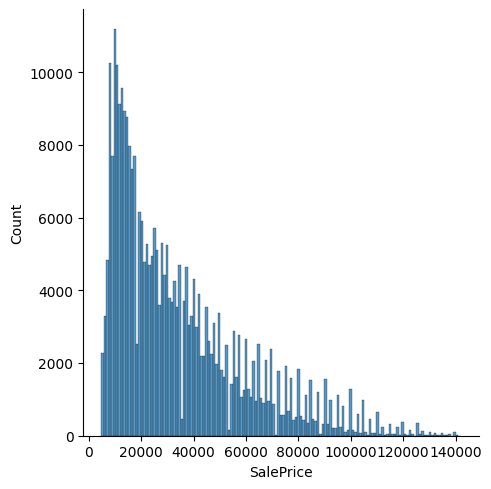

In [7]:
import seaborn as sns

sns.displot(df['SalePrice'])

Target variable has a strong correlation with Tweedie distributions, therefore we apply a simple logarithmic transformation to _normalize_ it:

In [2]:
target_var_transform = lambda x: np.log1p(x)

df['SalePrice_log1p'] = df['SalePrice'].apply(lambda x: target_var_transform(x))

mu, sigma = df['SalePrice_log1p'].mean(), df['SalePrice_log1p'].std()

df['SalePrice_log1p_norm'] = (df['SalePrice_log1p']-mu)/sigma

sns.displot(df['SalePrice_log1p_norm'])

NameError: name 'sns' is not defined

## Dataset

In [9]:
df.head()

,SalePrice,ProductGroup,Enclosure,Hydraulics,sale_day_sin,sale_day_cos,sale_month_sin,sale_month_cos,sale_year_sin,sale_year_cos,latitude,longitude,yearmade_norm,yearmade_sin,yearmade_cos,SalePrice_log1p,SalePrice_log1p_norm
0,66000,0,0,0,-0.101168,-0.994869,-0.500000,8.660254e-01,-9.898214e-01,0.142315,32.806671,-86.791130,0.991115,-0.055794,0.998442,11.097425,1.259911
1,57000,0,0,0,-0.848644,0.528964,1.000000,6.123234e-17,-9.096320e-01,-0.415415,35.630066,-79.806419,0.983218,-0.105248,0.994446,10.950824,1.062206
2,10000,1,1,1,-0.848644,0.528964,0.866025,5.000000e-01,-9.096320e-01,-0.415415,42.165726,-74.948051,0.988154,-0.074362,0.997231,9.210440,-1.284855
3,38500,2,0,0,-0.651372,-0.758758,0.500000,-8.660254e-01,-1.133108e-15,1.000000,31.054487,-97.563461,0.988154,-0.074362,0.997231,10.558439,0.533041
4,11000,1,2,1,-0.998717,-0.050649,-0.500000,-8.660254e-01,-5.406408e-01,0.841254,42.165726,-74.948051,0.994077,-0.037207,0.999308,9.305741,-1.156333


In [3]:
# Libraries
import torch
from typing import Tuple, List, Dict, Optional
from torch.utils.data import Dataset, DataLoader

# Main class
class BBBDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Convert all numerical features to float32 in one operation for efficiency
        numerical_features = {
            k: torch.tensor(self.X.loc[idx, k], dtype=torch.float32)
            for k in [
                'sale_day_sin', 'sale_day_cos',
                'sale_month_sin', 'sale_month_cos',
                'sale_year_sin', 'sale_year_cos',
                'latitude', 'longitude',
                'yearmade_norm', 'yearmade_sin', 'yearmade_cos'
            ]
        }
        
        # Categorical features remain as long
        categorical_features = {
            k: torch.tensor(self.X.loc[idx, k], dtype=torch.long)
            for k in ['ProductGroup', 'Enclosure', 'Hydraulics']
        }
        
        return {
            **categorical_features,
            **numerical_features,
            'label': torch.tensor(self.y[idx], dtype=torch.float32)
        }

# Data collator
class BBBCollator:
    def __init__(self):
        self.float_features = [
            'sale_day_sin', 'sale_day_cos',
            'sale_month_sin', 'sale_month_cos',
            'sale_year_sin', 'sale_year_cos',
            'latitude', 'longitude',
            'yearmade_norm', 'yearmade_sin', 'yearmade_cos'
        ]
        self.cat_features = ['ProductGroup', 'Enclosure', 'Hydraulics']
    
    def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
        # Stack all float features into single tensor
        X_float = torch.stack([
            torch.stack([item[feat] for feat in self.float_features])
            for item in batch
        ]).float()
        
        # Prepare categorical features as separate tensors
        X_cat = {
            feat: torch.stack([item[feat] for item in batch]).long()
            for feat in self.cat_features
        }
        
        # Prepare target
        y = torch.stack([item['label'] for item in batch]).float()
        
        return {'X_float': X_float, 'X_cat': X_cat}, y

# Check implementation
X, y = df[
    [
        'ProductGroup',
        'Enclosure',
        'Hydraulics',
        'sale_day_sin',
        'sale_day_cos',
        'sale_month_sin',
        'sale_month_cos',
        'sale_year_sin',
        'sale_year_cos',
        'latitude',
        'longitude',
        'yearmade_norm',
        'yearmade_sin',
        'yearmade_cos'
    ]
], df['SalePrice_log1p_norm'].values

train_dts = BBBDataset(X[:int(len(X)*0.8)].reset_index(drop=True), y[:int(len(X)*0.8)])
val_dts = BBBDataset(X[int(len(X)*0.8):].reset_index(drop=True), y[int(len(X)*0.8):])
collator = BBBCollator()
train_dtl = DataLoader(train_dts, batch_size=128, shuffle=True, collate_fn=collator)
val_dtl = DataLoader(val_dts, batch_size=256, shuffle=False, collate_fn=collator)

batch_X, batch_y = next(iter(train_dtl))
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
batch_X, batch_y = {"X_float": batch_X["X_float"].to(device), "X_cat": {k:v.to(device) for k,v in batch_X["X_cat"].items()}}, batch_y.to(device)

In [4]:
batch_X

{'X_float': tensor([[-0.6514, -0.7588,  0.5000,  ...,  0.9625, -0.2335,  0.9724],
         [ 0.1012, -0.9949, -1.0000,  ...,  0.9566, -0.2695,  0.9630],
         [ 0.9885,  0.1514,  0.8660,  ...,  0.9576, -0.2636,  0.9646],
         ...,
         [-0.9987, -0.0506, -1.0000,  ...,  0.9931, -0.0434,  0.9991],
         [-0.5713,  0.8208,  0.5000,  ...,  0.9911, -0.0558,  0.9984],
         [ 0.3944,  0.9190,  1.0000,  ...,  0.9862, -0.0867,  0.9962]],
        device='cuda:0'),
 'X_cat': {'ProductGroup': tensor([2, 0, 4, 4, 4, 0, 1, 2, 3, 0, 1, 3, 3, 0, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3,
          3, 0, 2, 3, 3, 3, 2, 2, 3, 0, 2, 1, 0, 0, 3, 2, 0, 3, 0, 2, 2, 3, 2, 3,
          2, 1, 3, 0, 0, 1, 4, 0, 1, 1, 1, 2, 3, 2, 2, 2, 0, 0, 0, 4, 0, 1, 1, 0,
          3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 4, 3, 2, 0, 4, 0, 3, 2, 2, 0, 4, 4, 3,
          1, 2, 3, 2, 0, 4, 3, 2, 3, 3, 3, 0, 0, 2, 4, 4, 3, 3, 1, 2, 1, 1, 3, 3,
          4, 2, 4, 2, 0, 2, 1, 4], device='cuda:0'),
  'Enclosure': tensor([2, 1, 2, 0,

## Modelling

In [5]:
from typing import Dict, Optional, Union, List
import torch
import torch.nn as nn

class BBBNet(torch.nn.Module):
    def __init__(
        self,
        hydraulics2id: Dict[str, int],
        enclosure2id: Dict[str, int],
        productgroup2id: Dict[str, int],
        hydraulics_proj_dim: Optional[int] = 2,
        enclosure_proj_dim: Optional[int] = 2,
        productgroup_proj_dim: Optional[int] = 2,
        dense_layers: List[int] = [32],  # List of layer sizes
        dropout_rates: Union[float, List[float]] = 0.1,  # Single or per-layer dropout rates
        use_batch_norm: bool = True,
        activation: str = "gelu"
    ):
        super().__init__()
        
        # Embedding layers
        self.embeddings_hydraulics = nn.Embedding(num_embeddings=len(hydraulics2id), embedding_dim=hydraulics_proj_dim)
        self.embeddings_enclosure = nn.Embedding(num_embeddings=len(enclosure2id), embedding_dim=enclosure_proj_dim)
        self.embeddings_productgroup = nn.Embedding(num_embeddings=len(productgroup2id), embedding_dim=productgroup_proj_dim)
        
        # Calculate total input features
        self.total_features = 11 + hydraulics_proj_dim + enclosure_proj_dim + productgroup_proj_dim
        
        # Process dense layer configuration
        self.dense_layers = dense_layers
        if not dense_layers:
            raise ValueError("dense_layers must contain at least one layer size")
            
        # Process dropout rates
        if isinstance(dropout_rates, float):
            self.dropout_rates = [dropout_rates] * len(dense_layers)
        else:
            if len(dropout_rates) != len(dense_layers):
                raise ValueError("dropout_rates must match length of dense_layers")
            self.dropout_rates = dropout_rates
            
        # Set activation function
        self.activation = self._get_activation(activation)
        
        # Create dense blocks
        self.dense_blocks = nn.ModuleList()
        in_features = self.total_features
        
        for i, out_features in enumerate(dense_layers):
            block = nn.ModuleDict()
            
            # Linear layer
            block['linear'] = nn.Linear(in_features, out_features)
            
            # BatchNorm (optional)
            if use_batch_norm:
                block['norm'] = nn.BatchNorm1d(out_features)
            
            # Dropout
            block['dropout'] = nn.Dropout(self.dropout_rates[i])
            
            self.dense_blocks.append(block)
            in_features = out_features
        
        # Final output layer
        self.output_layer = nn.Linear(in_features, 1)
        
    def _get_activation(self, activation: str) -> nn.Module:
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'leaky_relu': nn.LeakyReLU(),
            'selu': nn.SELU(),
            'silu': nn.SiLU()
        }
        return activations.get(activation.lower(), nn.GELU())
    
    def forward(self, inputs: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]): 
        # Process embeddings
        emb_h = self.embeddings_hydraulics(inputs['X_cat']['Hydraulics'])
        emb_e = self.embeddings_enclosure(inputs['X_cat']['Enclosure'])
        emb_pg = self.embeddings_productgroup(inputs['X_cat']['ProductGroup'])
        
        # Concatenate all features
        x = torch.cat([inputs['X_float'], emb_h, emb_e, emb_pg], dim=1)
        
        # Process through dense blocks
        for block in self.dense_blocks:
            x = block['linear'](x)
            
            if 'norm' in block:
                x = block['norm'](x)
            
            x = block['dropout'](x)    
            x = self.activation(x)
            
        
        # Final output
        x = self.output_layer(x)
        return x

# Check implementation
model = BBBNet(
    hydraulics2id=hydraulics2id,
    enclosure2id=enclosure2id,
    productgroup2id=productgroup2id,
    dense_layers=[64],  # Three hidden layers
    dropout_rates=0.1,  # Different dropout per layer
    use_batch_norm=True,
    activation='gelu',
)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

with torch.no_grad():
    batch_logits = model(batch_X)

## Loss, optimizer, scheduler

In [6]:
# Libraries
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts

# Loss & optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-2)

# Scheduler
scheduler_type = "step"
steps_per_epoch = len(train_dtl)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=steps_per_epoch, T_mult=2, eta_min=1e-5)

## Training loop

In [7]:
import wandb
from tqdm import tqdm

# ====== METRICS ======
def mean_absolute_percentage_error(preds, targets, epsilon=1e-8):
    """Calculates MAPE (%)"""
    return torch.mean(torch.abs((targets - preds) / (targets + epsilon))) * 100

# ====== TRAINING LOOP ======
def train_model_wandb(
    model,
    optimizer,
    train_loader,
    eval_loader,
    loss_module,
    num_epochs=100,
    patience=5,
    min_delta=0.001,
):
    wandb.init(project="bbb-regression", config={
        "learning_rate": optimizer.param_groups[0]['lr'],
        "architecture": "DNN-Regressor",
        "loss": "MSE",
        "scheduler": "CosineAnnealingWarmRestarts",
    })
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_eval_loss = float('inf')  # Tracks best validation loss
    best_eval_mape = float('inf')  # Tracks best validation MAPE
    patience_counter = 0  # Counts epochs without improvement
    model.to(device)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        # ===== TRAINING PHASE =====
        model.train()
        train_loss, train_mape = 0.0, 0.0
        num_samples = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Move data to device
            inputs = {
                "X_float": data["X_float"].to(device),
                "X_cat": {k: v.to(device) for k, v in data["X_cat"].items()}
            }
            targets = targets.to(device)

            # Forward pass
            preds = model(inputs).squeeze(-1)  # Ensure shape [batch_size]
            
            # Compute loss & metrics
            loss = loss_module(preds, targets)
            batch_mape = mean_absolute_percentage_error(preds, targets)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()  # Step per batch for CosineAnnealingWarmRestarts

            # Accumulate metrics
            train_loss += loss.item()
            train_mape += batch_mape.item()

            # Log batch metrics
            wandb.log({
                "batch_train_loss": loss.item(),
                "batch_train_mape": batch_mape.item(),
                "lr": optimizer.param_groups[0]['lr'],
            })

        # Epoch metrics
        epoch_train_loss = train_loss / len(train_dtl)
        epoch_train_mape = train_mape / len(train_dtl)

        # ===== EVALUATION PHASE =====
        model.eval()
        eval_loss, eval_mape = 0.0, 0.0

        with torch.no_grad():
            for data, targets in eval_loader:
                inputs = {
                    "X_float": data["X_float"].to(device),
                    "X_cat": {k: v.to(device) for k, v in data["X_cat"].items()}
                }
                targets = targets.to(device)
                preds = model(inputs).squeeze(-1)

                eval_loss += loss_module(preds, targets).item()
                eval_mape += mean_absolute_percentage_error(preds, targets).item()

        epoch_eval_loss = eval_loss / len(val_dtl)
        epoch_eval_mape = eval_mape / len(val_dtl)

        # Log epoch metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": epoch_train_loss,
            "train_mape": epoch_train_mape,
            "eval_loss": epoch_eval_loss,
            "eval_mape": epoch_eval_mape,
        })

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {epoch_train_loss:.4f} (MAPE: {epoch_train_mape:.2f}%) | "
            f"Val Loss: {epoch_eval_loss:.4f} (MAPE: {epoch_eval_mape:.2f}%)"
        )

        # ===== Early Stopping Check =====
        mape_improved = (epoch_eval_mape < best_eval_mape - min_delta)
        loss_improved = (epoch_eval_loss < best_eval_loss - min_delta)

        if mape_improved or loss_improved:
            # Update whichever metric improved
            if mape_improved:
                best_eval_mape = epoch_eval_mape
            if loss_improved:
                best_eval_loss = epoch_eval_loss

            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best: Loss={best_eval_loss:.4f}, MAPE={best_eval_mape:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping! No improvement for {patience} epochs.")
                print(f"Final metrics - Loss: {epoch_eval_loss:.4f}, MAPE: {epoch_eval_mape:.2f}%")
                break

    wandb.finish()

In [ ]:
train_model_wandb(model, optimizer, train_dtl, val_dtl, loss_fn, num_epochs=10)